In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):
    bonos = "SELECT TOP(" + str(n) + ") bono.Moneda, bono.TablaDesarrollo, bono.Base1 , bono.Base2, bono.FechaEmision, riesgo.Riesgo AS RiesgoInt, bono.Nemotecnico AS Nemotecnico FROM [dbAlgebra].[dbo].[TdNemoRF] AS bono , [dbAlgebra].[dbo].[VwRiesgoRF] AS riesgo,  [dbPortFolio].[dbo].[TdPlanvitalCartera] AS planvital WHERE bono.Nemotecnico = riesgo.Nemotecnico AND bono.FechaEmision > '20190101' AND bono.Nemotecnico = planvital.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)
    return pd.DataFrame(bonos)

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
#bonos = ajustes(bonos_dbAlgebra(1,cn))
#bonos

In [7]:
derivados = derivados_dBDerivados(5, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [8]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)


Moneda        Nombre   Nemotecnico     Inversion  \
0    CLP      AESGENER      AESGENER  1.709602e+09   
1    CLP       AGUAS-A       AGUAS-A  1.599324e+07   
2    CLP      ANDINA-A      ANDINA-A  1.492768e+08   
3    CLP      ANDINA-B      ANDINA-B  1.106085e+09   
4    CLP  DE000DWS2D90  DE000DWS2D90  1.213395e+10   
5    CLP    ANTARCHILE    ANTARCHILE  1.599258e+08   

                                           Historico  
0  [[0, 0.0025957870479299534, -0.007433469137058...  
1  [[0, 0.003305297208302039, 0.03566773260328181...  
2  [[0, 0.00034804011961498776, 0.018505998119275...  
3  [[0, 0.005746838657845234, 0.0175731917247771,...  
4  [[0, -0.011984448831005957, -0.025391621016988...  
5  [[0, 0.009876696995043567, 0.00310408270978682...  


{1: {('Renta Variable Nacional Acciones', 'Accion'): array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.5992584e+08]), ('Renta Variable Extranjera', 'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.21339496e+10, 0.00000000e+00]), ('Derivados', 'Derivado'): array([6.56639013e+10, 0.00000000e+00, 0.00000000e+00])}, 2: {('Acciones Electricas', 'Accion'): array([1.7096016e+09, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00]), ('Acciones Servicios', 'Accion'): array([       0., 15993240.,        0.,        0.,        0.,        0.]), ('Acciones Industrial', 'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.10608481e+09,
       0.00000000e+00, 0.00000000e+00]), ('Equities Europe', 'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.21339496e+10, 0.00000000e+00]), ('Acciones Recursos Naturales', 'Accion'): array([0.0000000

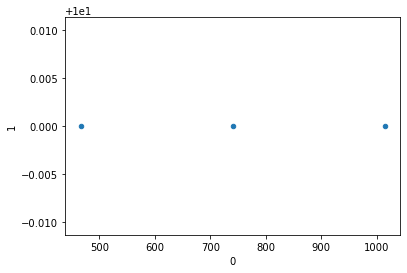

In [13]:
cartera = Cartera(acciones, pd.DataFrame(), derivados,'CLP', datetime.date(2019,2,1), cn, 60)

In [9]:
print(cartera.get_historicos_totales())

NameError: name 'cartera' is not defined

In [ ]:
print(cartera.get_retornos_totales())

In [ ]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())